# Trotterized Hamiltonian simulation with `qiskit` and `qiskit-ibm-runtime`

In this notebook, you will learn how to use a  **Multi-Product Formula (MPF)** to achieve a lower Trotter error on our observable compared to the one incurred by the deepest Trotter circuit that we will actually execute.
You will do so by working through the steps of a **Qiskit pattern**:

- **Step 1: Map to quantum circuits**
    - Initialize our problem's Hamiltonian
    - Generate a Trotter circuit
- **Step 2: Optimize the problem**
    - Transpile our circuits
- **Step 3: Execute experiments**
    - Use the `Estimator` primitive from qiskit runtime to compute our circuit's expectation values
        - Run local simulation
- **Step 4: Postprocess**
    - Inspect our results

## Step 1: Map to quantum problem

### 1a: Setting up our Hamiltonian

We use the XXZ model on a line of 12 sites:

$$
\hat{\mathcal{H}}_{XXZ} = \sum_{i=1}^{L-1} J_{i,(i+1)}\left(X_i X_{(i+1)}+Y_i Y_{(i+1)}+ 2\cdot Z_i Z_{(i+1)} \right) \, ,
$$

where $J_{i,(i+1)}$ is a random coefficient corresponding to edge $(i, i+1)$

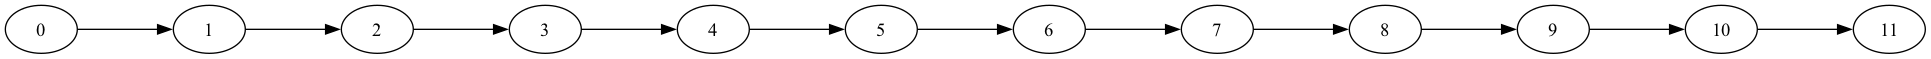

In [1]:
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw

# L = length of our 1D spin chain
L = 12

# Generate the edge-list for this spin-chain
elist = [(i-1,i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
even_edges  = elist[::2] 
odd_edges = elist[1::2]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(elist)
graphviz_draw(coupling_map.graph, method="circo")

#### Generate the hamiltonian we will evolve by

In [2]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Pauli

# Genereate random coefficients for our XXZ Hamiltonian
np.random.seed(0)
Js = np.random.rand(L-1) + 0.5*np.ones(L-1)
Js_fixed = np.zeros(L-1)

hamiltonian = SparsePauliOp(Pauli('I'*L))
for i, edge in enumerate(even_edges + odd_edges):
    Js_fixed[edge[0]] = Js[i]
    hamiltonian += SparsePauliOp.from_sparse_list(
    [("XX", (edge), Js[i] /2),
     ("YY", (edge), Js[i] /2),
     ("ZZ", (edge), Js[i] )], 
    num_qubits=L)

print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIXX', 'IIIIIIIIIIYY', 'IIIIIIIIIIZZ', 'IIIIIIIIXXII', 'IIIIIIIIYYII', 'IIIIIIIIZZII', 'IIIIIIXXIIII', 'IIIIIIYYIIII', 'IIIIIIZZIIII', 'IIIIXXIIIIII', 'IIIIYYIIIIII', 'IIIIZZIIIIII', 'IIXXIIIIIIII', 'IIYYIIIIIIII', 'IIZZIIIIIIII', 'XXIIIIIIIIII', 'YYIIIIIIIIII', 'ZZIIIIIIIIII', 'IIIIIIIIIXXI', 'IIIIIIIIIYYI', 'IIIIIIIIIZZI', 'IIIIIIIXXIII', 'IIIIIIIYYIII', 'IIIIIIIZZIII', 'IIIIIXXIIIII', 'IIIIIYYIIIII', 'IIIIIZZIIIII', 'IIIXXIIIIIII', 'IIIYYIIIIIII', 'IIIZZIIIIIII', 'IXXIIIIIIIII', 'IYYIIIIIIIII', 'IZZIIIIIIIII'],
              coeffs=[1.        +0.j, 0.52440675+0.j, 0.52440675+0.j, 1.0488135 +0.j,
 0.60759468+0.j, 0.60759468+0.j, 1.21518937+0.j, 0.55138169+0.j,
 0.55138169+0.j, 1.10276338+0.j, 0.52244159+0.j, 0.52244159+0.j,
 1.04488318+0.j, 0.4618274 +0.j, 0.4618274 +0.j, 0.9236548 +0.j,
 0.57294706+0.j, 0.57294706+0.j, 1.14589411+0.j, 0.46879361+0.j,
 0.46879361+0.j, 0.93758721+0.j, 0.6958865 +0.j, 0.6958865 +0.j,
 1.391773  +0.j, 0.73183138+0

#### Define the observable we want to estimate

In [3]:
observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L//2 - 1, L//2), 1.0)], num_qubits=L
)
print(observable)

SparsePauliOp(['IIIIIZZIIIII'],
              coeffs=[1.+0.j])


### 1c: Construct a Trotter circuit
We can use the `generate_time_evolution_circuit` function which is built on top of qiskit's `PauliEvolutionGate` to construct our trotter circuit

In [4]:
from qiskit import QuantumCircuit
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

total_time = 0.6
num_steps = 7

# Generate an initial state
initial_state = QuantumCircuit(L)
for i in range(L):
    if i%2:
        initial_state.x(i)

trotter_circuit = initial_state.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        time=total_time,
        synthesis=LieTrotter(reps=num_steps),
    ) 
)

fig = trotter_circuit.draw("mpl", fold = -1, scale = 0.2)

## Step 2: Optimize the problem

For the noiseless simulations we won't need to transpile, but for the hardware expeirments we will. Let's go ahead and transpile our PUBs

#### Create PUBs (Primitives Unified Blocs) which specify our experiment

In [5]:
pub_circuits    = [trotter_circuit]
pub_observables = [observable]
pubs = list(zip(pub_circuits, pub_observables))

### Transpile PUBs (circuits and observables) to match the backend ISA (Instruction Set Architecture)
By selecting `optimization_level=3`, the transpiler will choose a 1D chain of qubits which minimizes the noise affecting our circuit. Once we have converted our circuits into the format that the backend is prepared to accept, we will apply a complimentary transformation to our observables as well. 

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# need to create a service that's not local
service = QiskitRuntimeService(channel="ibm_quantum", instance='...')
backend = service.backend("ibm_torino")
estimator = Estimator(backend, options = estimator_options)

# Transpile pubs (circuits and observables) to match ISA
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuits = [pass_manager.run(circuit) for circuit in pub_circuits]
isa_observables = [obs.apply_layout(isa_circuit.layout) 
                                if isinstance(obs, SparsePauliOp) 
                                else [sub_obs.apply_layout(isa_circuit.layout) for sub_obs in obs]
                                for (isa_circuit, obs) in zip(isa_circuits, pub_observables)]
isa_pubs = zip(isa_circuits, isa_observables)


InvalidAccountError: 'Invalid `instance` value. Expected hub/group/project format, got ...'

## Step 3: Execute quantum experiments using `AerSimulator` backend

We can simulate our various Trotter circuits, including the back-propagated one using the ``Estimator`` primitive from ``qiskit-ibm-runtime`` and we will compare the results we get with a Trotter circuit of 100 steps. 
These simulations do not have any sources of noise apart from statistical uncertainty due to drawing finitely many shots.

### Noiseless local simulation

In [ ]:
# Import Qiskit Runtime service and Estimator
# V2 is the default version in qiskit-ibm-runtime>=0.28.0, no need to import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

num_shots = 2**20

# Instantiate a local Estimator using a Simulator
local_service = QiskitRuntimeService(channel="local")
simulator = local_service.backend("aer_simulator")
simulator_estimator = Estimator(simulator)

# Simulate experiments, retrieve epxectation values
noiseless_result = simulator_estimator.run(pubs, precision=1/np.sqrt(num_shots)).result()
noiseless_expval = [pub_result.data.evs.tolist() for pub_result in noiseless_result]


In [ ]:
print(f"Expectation Value: {noiseless_expval[0]:3f}")